In [2]:
import os
import time
import numpy as np

In [3]:
def load_embeddings(embeddings_path):
    embeddings = {}
    with open(embeddings_path, 'r') as file:
        for line in file:
            splits = line.split()
            word = splits[0]
            coords = np.asarray(splits[1:], dtype='float32')
            embeddings[word] = coords
    return embeddings

In [4]:
word_embeddings = load_embeddings('./glove.6B.300d.txt')

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [25]:
def get_word_embedding(category, word_embeddings, wordvec_size=300):
    if category in word_embeddings:
        return word_embeddings[category]
    return np.zeros(shape=wordvec_size)

def get_word_embedding_from_description(description, word_embeddings, wordvec_size=300):
    stop_words = set(stopwords.words('english'))
    stop_words.add(";")
    words = word_tokenize(description)
    wordvecs = []

    for word in words:
        if word not in stop_words:
            word_embedding = get_word_embedding(word, word_embeddings, wordvec_size)
            wordvecs.append(word_embedding)

    return np.mean(np.array(wordvecs), axis=0)

def preprocess_iaprtc12_images(path, word_embeddings, wordvec_size=300):
    image_list = []
    labels_list = []
    paths_list = []
    no_desc_images = []
    
    for dir_path, dir_names, image_names in os.walk(os.path.join(path, "images")):
        if not image_names: # skip current directory listing
            continue

        desc_dir_path = dir_path.replace("/images/", "/annotations_complete_eng/")
        for img_name in image_names:
            full_path = os.path.join(dir_path, img_name)
            
            desc_file = os.path.join(desc_dir_path, img_name).replace(".jpg", ".eng")
            if os.path.exists(desc_file):
                word_embedding = np.array([])
                with open(desc_file, 'r', errors='replace') as desc:
                    desc_line = desc.readlines()[3]
                    description = desc_line.replace("<DESCRIPTION>", "").replace("</DESCRIPTION>", "")
                    word_embedding = get_word_embedding_from_description(description, word_embeddings)

                img_pil = image.load_img(full_path, target_size=(224, 224))
                img_raw = image.img_to_array(img_pil)
                img = preprocess_input(img_raw) # VGG16 image preprocessing.

                image_list.append(img)
                labels_list.append(word_embedding)
                paths_list.append(full_path)
            
            else:
                no_desc_images.append(full_path)
    return np.array(image_list), np.array(labels_list), paths_list, no_desc_images

In [27]:
images_vgg16, image_embeddings, image_paths, no_desc_images = preprocess_iaprtc12_images("./iaprtc12", word_embeddings)

In [8]:
images_vgg16.shape

(9832, 224, 224, 3)

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.losses import cosine_similarity

In [30]:
def hybrid_model_backbone(intermediate_dim=2000, word_embedding_dim=300):
    vgg16 = VGG16(input_shape=images_vgg16.shape[1:])
    x = vgg16.get_layer('fc2').output

    for layer in vgg16.layers:
        layer.trainable = False

    x = Dense(intermediate_dim, name="dense1")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = Dense(word_embedding_dim, name="dense2")(x)
    outputs = BatchNormalization()(x)

    model = Model(inputs=[vgg16.input], outputs=outputs)
    # https://faroit.com/keras-docs/2.0.8/optimizers/
    sgd = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss=cosine_similarity)
    return model

In [31]:
hybrid_model = hybrid_model_backbone()

In [32]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [33]:
def get_model_trained(model, X, y, model_path, train_model=False):
    if train_model: 
        epochs, batch_size = (20, 32)
        X, y = shuffle(X, y, random_state=7)
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.3, random_state=7)
        checkpointer = ModelCheckpoint(
            filepath='best.hdf5', verbose=1, save_best_only=True)
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[checkpointer])
        model.save(model_path)
        return model
    # Assuming that there is a model in a given path.
    else:
        return load_model(model_path)

In [34]:
hybrid_model = get_model_trained(hybrid_model, images_vgg16, image_embeddings, "./model_and_index_iaprtc12/model_new", train_model=False)

In [19]:
from annoy import AnnoyIndex

In [36]:
def get_annoy_index(vectors_list, number_of_trees=20, dims=300):
    annoy_index = AnnoyIndex(dims, 'angular')
    for i, vec in enumerate(vectors_list):
        annoy_index.add_item(i, vec)
    annoy_index.build(number_of_trees)
    return annoy_index

def generate_word_annoy_index(word_embeddings):
    word_index = dict(enumerate(word_embeddings))
    word_embeddings_list = [word_embeddings[word] for word in word_index.values()]
    annoy_index = get_annoy_index(word_embeddings_list)
    return annoy_index, word_index

In [37]:
# This might take minute or two (since it is a 400k corpus of 300d words).
word_annoy_index, word_index = generate_word_annoy_index(word_embeddings)

In [11]:
import json

In [15]:
def generate_image_embeddings(image_paths, model):
    images = np.zeros(shape=images_vgg16.shape)
    image_path_index = dict(enumerate(image_paths))

    for ind, path in image_path_index.items():
        img_pil = image.load_img(path, target_size=images_vgg16.shape[1:-1])
        img_raw = image.img_to_array(img_pil)
        images[ind, :, :, :] = img_raw

    image_embeddings_list = model.predict(preprocess_input(images))
    return image_embeddings_list, image_path_index

def load_image_embeddings(vectors_filename, mapping_filename):
    image_embeddings = np.load("%s.npy" % vectors_filename)
    with open("%s.json" % mapping_filename) as f:
        image_path_index = json.load(f)
        return image_embeddings, {int(k): v for k, v in image_path_index.items()}

def save_image_embeddings(image_embeddings_filename,
                          image_embeddings,
                          mapping_filename, 
                          image_path_index):
    np.save("%s.npy" % image_embeddings_filename, image_embeddings)
    with open("%s.json" % mapping_filename, 'w') as index_file:
        json.dump(image_path_index, index_file)

In [16]:
def nearest_neighbors(vector, annoy_index, item_index, k=10):
    distances = annoy_index.get_nns_by_vector(vector, k, include_distances=True)
    return [[a, item_index[a], distances[1][i]] for i, a in enumerate(distances[0])]

In [17]:
def get_hybrid_embeddings(generate_embeddings=False):
    image_hybrid_embeddings_filepath = "./model_and_index_iaprtc12/image_embeddings"
    image_path_indexes_filepath = "./model_and_index_iaprtc12/image_path_indexes"
    # Generating embedding might take 5-10min.
    if generate_embeddings:
        image_hybrid_embeddings, image_path_index = \
            generate_image_embeddings(image_paths, hybrid_model)
        save_image_embeddings(image_hybrid_embeddings_filepath,
                              image_hybrid_embeddings,
                              image_path_indexes_filepath,
                              image_path_index)
        return image_hybrid_embeddings, image_path_index
    else:
        image_hybrid_embeddings, image_path_index = \
            load_image_embeddings(image_hybrid_embeddings_filepath, 
                                  image_path_indexes_filepath)
    return image_hybrid_embeddings, image_path_index

In [20]:
image_hybrid_embeddings, image_path_index = get_hybrid_embeddings(generate_embeddings=False)
image_annoy_index = get_annoy_index(image_hybrid_embeddings, number_of_trees=1000)

# DEMO

In [21]:
from IPython.display import Image
from IPython.display import HTML, display
import urllib.request

In [22]:
def display_similar_images(mean_embedding, image_path=None):
    closest_images = nearest_neighbors(mean_embedding, image_annoy_index, image_path_index)

    html_str = "<script>$('div.cell.selected').next().height(100);</script>\n"
    if image_path is not None:
        html_str += "<h1>Our input image</h1>"
        html_str += "<img src='%s'>" % image_path
        html_str += "<h1>Similar images</h1>"
    html_str += "<table>"

    for i in range(0, 5):
        left_cell = closest_images[2*i][1]
        html_str += "<tr><td><img src='%s'></td>" % left_cell
        right_cell = closest_images[2*i+1][1]
        html_str += "<td><img src='%s'></td></tr>" % right_cell
    html_str += "</table>\n"

    display(HTML(html_str))

def search_by_text(text):
    mean_embedding = np.mean([word_embeddings[word] for word in text.split()], axis=0)
    display_similar_images(mean_embedding)

def get_image_labels(image_path, display_image=False):
    if display_image:
        display(Image(filename=image_path))
    
    images = np.zeros(shape=(1,)+images_vgg16.shape[1:])
    img = image.load_img(image_path, target_size=images_vgg16.shape[1:-1])
    x_raw = image.img_to_array(img)
    images[0] = np.expand_dims(x_raw, axis=0)

    inputs = preprocess_input(images)

    image_features = hybrid_model.predict(inputs)[0]
    closest_labels = nearest_neighbors(image_features, word_annoy_index, word_index)
    return closest_labels

def search_similar_images(image_location, from_url=False):
    image_path = image_location
    if from_url:
        filename = image_location.split("/")[-1]
        urllib.request.urlretrieve(image_location, filename)
        image_path = filename

    closest_labels = [l for _, l, _ in get_image_labels(image_path)]
    mean_embedding = np.mean([word_embeddings[label] for label in closest_labels], axis=0)
    display_similar_images(mean_embedding, image_path)

*Identifying labels on some pictures from the dataset:*

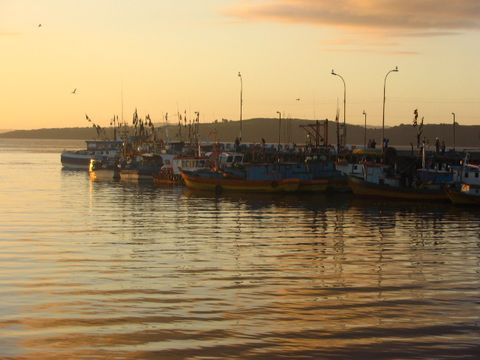

[[385, 'along', 0.8607505559921265],
 [111, 'where', 0.8746403455734253],
 [2, '.', 0.8912869691848755],
 [357, 'small', 0.8942393660545349],
 [937, 'sea', 0.8960348963737488],
 [531, 'across', 0.9089937210083008],
 [541, 'seen', 0.9130023717880249],
 [430, 'water', 0.9169284701347351],
 [204, 'around', 0.9178614020347595],
 [5, 'and', 0.919707715511322]]

In [38]:
get_image_labels(image_paths[223], display_image=True)

*Searching for specific category/label:*

In [46]:
search_by_text("plane")

,
,
,
,
,


*Searching for categories that are not in image dataset:*

In [47]:
search_by_text("birds")

,
,
,
,
,


In [29]:
search_by_text("ocean")

,
,
,
,
,


In [30]:
search_by_text("street")

,
,
,
,
,


*Achieving more complex queries by combining words:*

In [32]:
search_by_text("bird near water")

,
,
,
,
,


*Since we are able to identify labels on an image, we can perform search by image:*

In [33]:
search_similar_images(image_paths[650])

,
,
,
,
,


In [34]:
search_similar_images(image_paths[711])

,
,
,
,
,


*The same goes for images outside of the dataset*

In [37]:
search_similar_images('./demo_images/moor-moorland-grasses-wetland-nature-conservation-nature-reserve-nature-landscape-wetlands.jpg')

,
,
,
,
,


In [41]:
search_by_text("fence")

,
,
,
,
,


In [42]:
search_by_text("sky")

,
,
,
,
,


In [43]:
search_by_text("snow")

,
,
,
,
,
